In [80]:
import json
from collections import Counter

import pandas as pd
import seaborn as sns
import pingouin as pg

df = (
    pd.read_csv("../data/testResults_from_2025-05-07.csv")
    # Convert dictionaries to lists
    .assign(
        answers=lambda x: x["answers"].apply(
            lambda row: list(json.loads(row).values())
        ),
        correctAnswers=lambda x: x["correctAnswers"].apply(
            lambda row: list(json.loads(row).values())
        ),
        annotation_counts=lambda x: x["annotations"].apply(
            lambda row: Counter(json.loads(row).values())
        ),
        annotations=lambda x: x["annotations"].apply(
            lambda row: list(json.loads(row).values())
        ),
    )
    # Calculate percentage correct
    .assign(
        pct_correct=lambda x: x.apply(
            lambda row: sum(
                a == c for a, c in zip(row["answers"], row["correctAnswers"])
            )
            / len(row["answers"])
            * 100,
            axis=1,
        )
    )
)

df.sample(2)

,id,userId,method,passageId,score,timeSpent,answers,correctAnswers,annotations,holisticScore,timestamp,annotation_counts,pct_correct
22,Xq3GVJQ5Lh7dx61D3uMv,FJ0pkfomjHUVSnW3EdJKRxM3lzN2,keyword,4,88.888889,532.417,"[approach, empirical, questions, judgments, sc...","[approach, empirical, questions, questions, sc...","[sentence, sentence, sentence, source, sentenc...",2,2025-05-10T07:48:39.261Z,"{'sentence': 8, 'source': 1}",88.888889
30,gtme2adseUp50UIeQtRe,8KxKTuoybIbVnALkryXvGxhTKED3,contextuality,10,40.000000,2324.491,"[behavior, desires, behavior, cultures, view, ...","[cultures, freedom, cultures, cultures, like, ...","[passage, source, passage, source, sentence, s...",3,2025-05-11T19:34:28.661Z,"{'passage': 3, 'source': 3, 'sentence': 4}",30.000000


## Stuff we want to Know

The following, separately for each cloze generation method:
- Holistic: Overall human rating of cloze exercise
- Per-gap Ratings: Proportion of gaps that are unpredictable, source predictable, local predictable, or global predictable.
- Score: Percentage of Answers Correct
- Time Spent
- Associations between correct/incorrect answers and per-gap ratings.

In [81]:
# Num Gaps
df.groupby("method")["correctAnswers"].apply(lambda x: x.str.len().mean())

method
contextuality         9.448276
contextuality_plus    9.000000
keyword               5.842105
Name: correctAnswers, dtype: float64

In [82]:
# Holistic Score
df.groupby("method")["holisticScore"].mean().round(2)

method
contextuality         2.38
contextuality_plus    2.91
keyword               2.42
Name: holisticScore, dtype: float64

<Axes: xlabel='method', ylabel='timeSpent'>

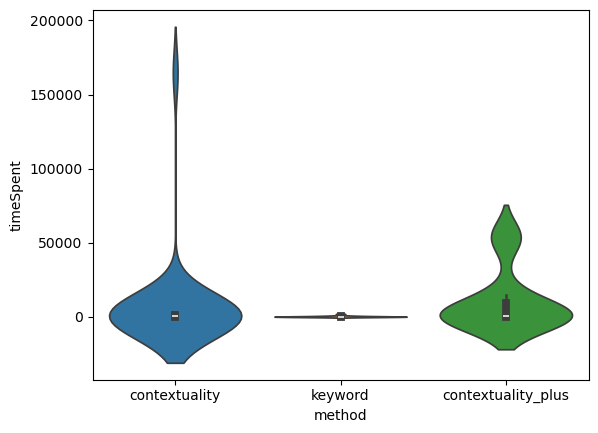

In [83]:
# Time Spent
# Very not normal. Report percentiles.
df.groupby("method")["timeSpent"].describe()

sns.violinplot(data=df, x="method", y="timeSpent", hue="method")

In [84]:
# Percent Correct
df.groupby("method")["pct_correct"].mean().round(2)

method
contextuality         60.20
contextuality_plus    71.33
keyword               87.28
Name: pct_correct, dtype: float64

In [85]:
# Per-gap Ratings
count_df = pd.DataFrame(index=["unpredictable", "sentence", "passage", "source"])

for name, grp in df.groupby("method")["annotation_counts"]:
    counter = Counter()
    for cntr in grp:
        counter.update(cntr)

    counts = pd.DataFrame.from_dict(counter, orient="index")[0]  # Extract the series
    percentages = (counts / counts.sum()) * 100
    count_df[name] = [f"{counts[x]} ({percentages[x]:.0f}%)" for x in count_df.index]

display(count_df)

,contextuality,contextuality_plus,keyword
unpredictable,47 (17%),31 (15%),3 (3%)
sentence,94 (34%),70 (34%),41 (37%)
passage,48 (18%),37 (18%),41 (37%)
source,85 (31%),69 (33%),26 (23%)


In [86]:
# One-way ANOVA
anova_result = pg.anova(data=df, dv="holisticScore", between="method")
display(anova_result)

# Post-hoc pairwise comparisons
posthoc = pg.pairwise_tukey(data=df, dv="holisticScore", between="method")
display(posthoc)

,Source,ddof1,ddof2,F,p-unc,np2
0,method,2,68,2.570383,0.083923,0.070286


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,contextuality,contextuality_plus,2.379310,2.913043,-0.533733,0.251761,-2.119997,0.093306,-0.671384
1,contextuality,keyword,2.379310,2.421053,-0.041742,0.266131,-0.156849,0.986531,-0.045499
2,contextuality_plus,keyword,2.913043,2.421053,0.491991,0.279534,1.760041,0.190836,0.468529


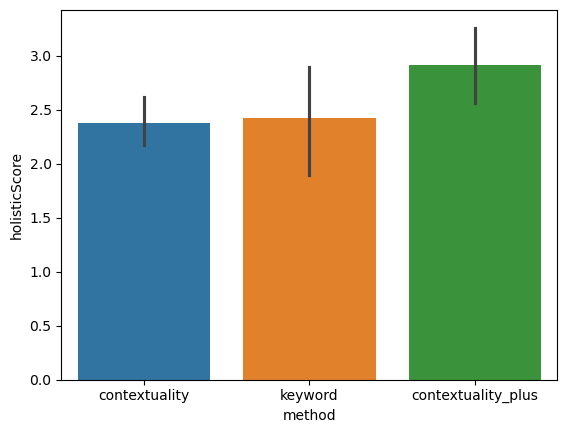

In [87]:
sns.barplot(df, x="method", y="holisticScore", hue="method", legend=False);

# Per-gap Ratings Deep Dive

In [90]:
guesses = []
correct_answers = []
ratings = []

for row in df.itertuples():
    guesses.extend(row.answers)
    correct_answers.extend(row.correctAnswers)
    ratings.extend(row.annotations)

assert len(guesses) == len(correct_answers) == len(ratings)

In [102]:
correct_counter = Counter()
incorrect_counter = Counter()
no_guess = 0

for guess, correct_answer, rating in zip(guesses, correct_answers, ratings):
    if guess == correct_answer:
        correct_counter[rating] += 1
    else:
        if rating == "unpredictable":
            # print(f"Guess:  {guess}")
            # print(f"Answer: {correct_answer}")
            # print()
            if guess.strip() == "" or guess == "unanswered":
                no_guess += 1
            else:
                incorrect_counter[rating] += 1
        else:
            incorrect_counter[rating] += 1


print(no_guess)
print("  Correct Counter: ", correct_counter)
print("Incorrect Counter: ", incorrect_counter)

18
  Correct Counter:  Counter({'sentence': 156, 'source': 145, 'passage': 99, 'unpredictable': 9})
Incorrect Counter:  Counter({'unpredictable': 54, 'sentence': 49, 'source': 35, 'passage': 27})
